In [1]:
# from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

# Analyzing the Gutenberg Books Corpus

In this notebook, we will use the cleaned, pre-processed data that we created in the [pre-processing part](gutenberg-preprocessing-SOLUTIONS.ipynb). As a reminder, we ended up with an RDD of `(gid, text)` tuples that has been cleaned and we stored it on HDFS at `/user/<YOUR_USERNAME>/gutenberg/cleaned_rdd`. 

In the [first analysis notebook](gutenberg-analysis-SOLUTIONS.ipynb) we build an N-gram viewer for the gutenberg books project. Now, we will use the corpus to train a simple language classification model using [Spark's machine learning library](http://spark.apache.org/docs/latest/mllib-guide.html).

## Load the data from HDFS

In [3]:
# TODO: load cleaned_rdd from the HDFS
cleaned_rdd = sc.pickleFile('/user/roskarr/gutenberg/cleaned_rdd').setName('cleaned_rdd').cache()

### A brief aside - correcting for data skew

Before we begin the loop-heavy analysis, we can do one more bit of optimization. Not all of the books in the corpus are the same length. This means that when we extract the ngrams, the differences will become even more pronounced. Since our basic unit of work here is a full book, this will result in uneven task execution times. Furthermore, because an individual "task" will actually process many books, this means that shorter books will be stuck in the queue behind longer books. 

To visualize this, lets count the number of characters in each partition: 

In [4]:
def count_chars_in_partition(iterator): 
    """
    Sum up the string lengths in each partition
    """
    c = 0
    for (gid, text) in iterator: 
        c+=len(text)
    yield c    

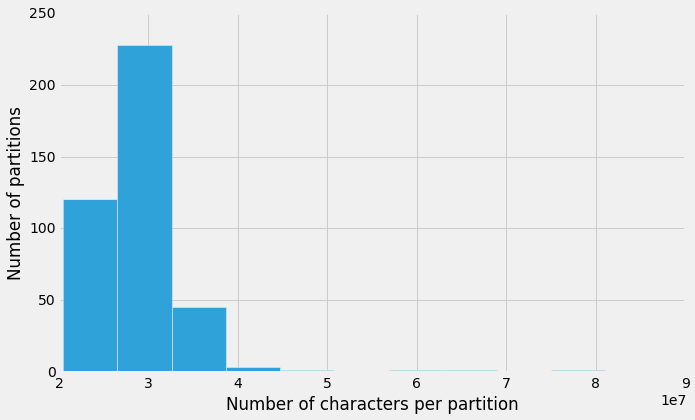

In [5]:
plt.hist(cleaned_rdd.mapPartitions(count_chars_in_partition).collect())
plt.xlabel('Number of characters per partition')
plt.ylabel('Number of partitions')

It's easy to see that some of the partitions have much more data than others. You can also verify this by looking at the Spark web UI for your job and clicking on the last stage that just executed (it will be named "collect"). You should see something like this at the top of the page: 

![Task summary](../figs/summary_tasks.png)

You can see that the longest tasks are taking several times more to execute than the mean even for this extremely simple operation. The data skew is clear if you scroll down a bit more and see the actual data input into each task and sort by duration: 

![Task duration](../figs/task_duration.png)

The longest few tasks are processing considerably more data than even the next several. Such a data skew may not matter for certain applications, but in our case we can expect it to make a difference. 

To try and correct it, we must first realize that for our application we have very few requirements about text order. We don't care about the order of words, as long as the documents are tagged with the correct language. So splitting a book into two and processing them out of order doesn't really matter. 

With this in mind, we can use a function like `chunk_text` below that creates approximately equal-sized "blocks" of text. The blocking means we'll get some spurious character ngrams at the beginning and end of each document, but if we block the data in large enough chunks this shouldn't matter too much.

In [7]:
def chunk_text(text, block_len=10000) : 
    """
    Ensure that blocks of text are no larger than `block_len`.
    
    Arguments: 
        
        text: the raw text string
    """
    len_text = len(text)
    
    if len_text < block_len : 
        return text
    else : 
        nblocks = len_text/block_len
        return [text[i*block_len:(i+1)*block_len] for i in xrange(nblocks)]

Now we apply this function to the `cleaned_rdd` and visualize the partition size distribution again. Since we want to keep the keys untouched, we can use the `flatMapValues` RDD method. However, since this method keeps the same data within each partition, we also need to *repartition* the data afterwards to randomize the chunk distributions. 

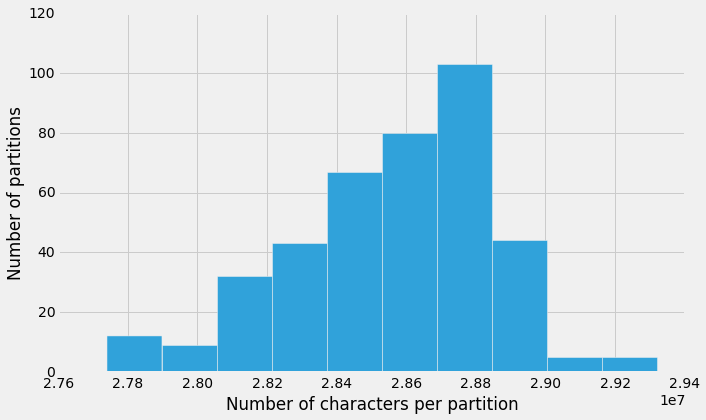

In [8]:
plt.hist(cleaned_rdd.flatMapValues(chunk_text)
                    .repartition(400)
                    .mapPartitions(count_chars_in_partition)
                    .collect())
plt.xlabel('Number of characters per partition')
plt.ylabel('Number of partitions')

The distribution is now still not perfect, but we have corrected it considerably. Lets make a restructured version of the full dataset and cache it: 

In [9]:
equalized_rdd = (cleaned_rdd.flatMapValues(chunk_text)
                            .setName('equalized_rdd')
                            .repartition(400)).cache()

### Load in the metadata dictionary and broadcast it

Just as in the previous notebook, we will load our pre-generated metadata dictionary and broadcast it to all the executors. 

In [11]:
from cPickle import load

with open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'r') as f :
    meta_dict = load(f)

In [12]:
# TODO: create meta_b by broadcasting meta_dict
meta_b = sc.broadcast(meta_dict)

Now, our `cleaned_rdd` contains `gid`'s as keys and text as values and if we want some other piece of metadata, we can just access it via the lookup table, for example `meta_b.value[gid][meta_name]`. 

We will use the same `extract_ngrams` and `vectorize_doc` functions as in the previous notebook: 

In [13]:
from pyspark.mllib.linalg import SparseVector

def extract_ngrams(tokens, ngram_range=[1,1], select_ngrams = None, ngram_type='word'):
    """
    Turn tokens into a sequence of n-grams 

    **Inputs**:

    *tokens*: a list of tokens

    **Optional Keywords**:

    *ngram_range*: a tuple with min, max ngram ngram_range
    
    *select_ngrams*: the vocabulary to use
    
    *ngram_type*: whether to produce word or character ngrams

    **Output**

    Generator yielding a list of ngrams in the desired range
    generated from the input list of tokens

    """
    join_str = "" if ngram_type=='character' else " "
    
    # handle token n-grams
    min_n, max_n = ngram_range
    n_tokens = len(tokens)
    
    for n in xrange(min_n, min(max_n + 1, n_tokens + 1)):
        for i in xrange(n_tokens - n + 1):
            if n == 1: 
                res = tokens[i]
            else : 
                res = join_str.join(tokens[i: i+n])
           
            # if we are using a lookup vocabulary, check for membership here
            if select_ngrams is not None : 
                if res in select_ngrams: 
                    yield res
            else : 
                yield res
            
def vectorize_doc(doc, vocab, ngram_range = [1,1], ngram_type='word') : 
    """
    Returns a vector representation of `doc` given the reference 
    vocabulary `vocab` after tokenizing it with `tokenizer`
    
    Arguments: 
        
        doc: a sequence of tokens (words or characters)
        
        vocab: the vocabulary mapping
        
    Keywords:
    
        ngram_range: the range of ngrams to process
        
        ngram_type: whether to produce character or word ngrams; default is 
        
    Returns:
    
        a sparse vector representation of the document given the vocabulary mapping
    """
    from collections import defaultdict
    from scipy.sparse import csr_matrix 
        
    # count all the word occurences 
    data = np.zeros(len(vocab))
    
    for ngram in extract_ngrams(doc, ngram_range, vocab, ngram_type) : 
         data[vocab[ngram]] += 1
            
    # only keep the nonzero indices for the sparse representation
    indices = data.nonzero()[0]
    values = data[indices]
    
    return SparseVector(len(vocab), indices, values)

# Language classification

Here we will try to use some of the same techniques we developed before, but apply them to a classification problem: determining whether a text is English or German. 

We will use the rather straightforward method outlined in [Cavnar & Trenkle 1994](http://odur.let.rug.nl/~vannoord/TextCat/textcat.pdf):

For each of the English/German training sets:

1. tokenize the text (spaces are also tokens, so we replace them with "_")
2. extract N-grams where 1 < N < 5
3. determine the most common N-grams for each corpus
4. encode both sets of documents using the combined top ngrams



In the last notebook, we used words as "tokens" -- now we will use characters, even accounting for white space (which we will replace with "_"). We will use the two example sentences again:

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
First, we use the `extract_ngrams` function: 

In [14]:
s1 = "a dog bit me"
s2 = "i bit the dog back"

In [15]:
ngrams1 = list(extract_ngrams(s1.replace(' ','_'), ngram_range=[1,5], ngram_type='character'))
ngrams2 = list(extract_ngrams(s2.replace(' ','_'), ngram_range=[1,5], ngram_type='character'))

In [16]:
print(list(ngrams1))

['a', '_', 'd', 'o', 'g', '_', 'b', 'i', 't', '_', 'm', 'e', 'a_', '_d', 'do', 'og', 'g_', '_b', 'bi', 'it', 't_', '_m', 'me', 'a_d', '_do', 'dog', 'og_', 'g_b', '_bi', 'bit', 'it_', 't_m', '_me', 'a_do', '_dog', 'dog_', 'og_b', 'g_bi', '_bit', 'bit_', 'it_m', 't_me', 'a_dog', '_dog_', 'dog_b', 'og_bi', 'g_bit', '_bit_', 'bit_m', 'it_me']


We can create the vocabulary by getting the set of all ngrams and building a lookup table:

In [17]:
vocab = set(ngrams1) | set(ngrams2)

In [18]:
vocab_dict = {word:ind for ind,word in enumerate(vocab)}
print('number of ngrams: ',len(vocab_dict))

('number of ngrams: ', 89)


Note that extracting ngrams can increase the size of the data quite a lot!

In [19]:
vocab_dict

{'_': 73,
 '_b': 24,
 '_ba': 12,
 '_bac': 19,
 '_back': 27,
 '_bi': 8,
 '_bit': 29,
 '_bit_': 54,
 '_d': 23,
 '_do': 55,
 '_dog': 83,
 '_dog_': 72,
 '_m': 18,
 '_me': 84,
 '_t': 15,
 '_th': 71,
 '_the': 36,
 '_the_': 31,
 'a': 74,
 'a_': 66,
 'a_d': 34,
 'a_do': 58,
 'a_dog': 88,
 'ac': 5,
 'ack': 62,
 'b': 41,
 'ba': 68,
 'bac': 67,
 'back': 25,
 'bi': 70,
 'bit': 37,
 'bit_': 6,
 'bit_m': 35,
 'bit_t': 30,
 'c': 75,
 'ck': 0,
 'd': 42,
 'do': 26,
 'dog': 81,
 'dog_': 7,
 'dog_b': 9,
 'e': 76,
 'e_': 64,
 'e_d': 49,
 'e_do': 21,
 'e_dog': 51,
 'g': 77,
 'g_': 14,
 'g_b': 59,
 'g_ba': 63,
 'g_bac': 22,
 'g_bi': 65,
 'g_bit': 3,
 'h': 44,
 'he': 38,
 'he_': 4,
 'he_d': 50,
 'he_do': 11,
 'i': 78,
 'i_': 60,
 'i_b': 57,
 'i_bi': 28,
 'i_bit': 85,
 'it': 56,
 'it_': 17,
 'it_m': 53,
 'it_me': 33,
 'it_t': 43,
 'it_th': 69,
 'k': 79,
 'm': 80,
 'me': 39,
 'o': 82,
 'og': 47,
 'og_': 40,
 'og_b': 2,
 'og_ba': 13,
 'og_bi': 16,
 't': 48,
 't_': 1,
 't_m': 61,
 't_me': 32,
 't_t': 87,
 't_th'

And finally, we can use `vectorize_doc` with the vocabulary mapping to turn the documents into vectors: 

In [20]:
vectorize_doc(s1.replace(' ','_'), vocab_dict, ngram_range=[1,5], ngram_type='character')

SparseVector(89, {1: 1.0, 2: 1.0, 3: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 14: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 23: 1.0, 24: 1.0, 26: 1.0, 29: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 37: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 47: 1.0, 48: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 58: 1.0, 59: 1.0, 61: 1.0, 65: 1.0, 66: 1.0, 70: 1.0, 72: 1.0, 73: 3.0, 74: 1.0, 76: 1.0, 77: 1.0, 78: 1.0, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 88: 1.0})

As a dense vector, this looks like: 

In [21]:
vectorize_doc(s1.replace(' ','_'), vocab_dict, ngram_range=[1,5], ngram_type='character').toArray()

array([ 0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.])

### Saving memory consumption with `mapPartitions`

As you could see from the simple example of extracting ngrams from two short phrases above, by extracting the 1-5 grams from a simple 12-character string, we created a vector with 48 stored values. Our actual documents will therefore swell in size very rapidly -- we definitely don't want to be holding all of those huge lists in memory! 

Remember, our first goal is to get the top most-used N-grams. For this, we just need to create an RDD of N-grams and to avoid building lists we'll use the technique of generators discussed on the first day. 

Note that the `extract_ngrams` function above is already a generator: now we just want to make a small wrapper function that uses `extract_ngrams` to "yield" ngrams one by one into the RDD. 

A slight complication is that `mapPartitions` gives us a partition *iterator* over the data in the partition. This iterator will give us partition data one element at a time, which in this case are just the individual documents. We can pass each of these documents to `extract_ngrams`. 

In [24]:
from collections import defaultdict

def ngram_generator(iterator, ngram_range=[1,1], ngram_type='word') : 
    """Take an iterator of documents and create a generator of ngrams
    
    Arguments:
        
        iterator: the document iterator
        
    Keywords:
        
        ngram_range: the range of ngrams to consider
        
        ngram_type: whether to extract word or character ngrams; default is word
    """ 
    for text in iterator : 
        for ngram in extract_ngrams(text.replace(' ', '_'), ngram_range, ngram_type=ngram_type): 
            yield ngram

We will subsample the `equalized_rdd` in order to make this next set of cells complete in a reasonable amount of time -- once it's working, you can go back and do it for the full dataset, but it will take approximately 30 minutes. Note that we also repartition the data in order to ease the resource requirements of individual partitions. 

In [25]:
sampled_rdd = equalized_rdd.sample(False, 0.2).cache()

In [26]:
# TODO: create english_rdd and german_rdd by filtering the sampled_rdd for 'en' and 'de' 
english_rdd = sampled_rdd.filter(lambda (gid, text): (meta_b.value[gid]['lang'] == 'en')).setName('english_rdd').cache()
german_rdd  = sampled_rdd.filter(lambda (gid, text): (meta_b.value[gid]['lang'] == 'de')).setName('german_rdd').cache()

ngram_range = [1,3] # should use 1-5 ngram range, but make it smaller to speed up the processing a bit

#### Making the sets of most common english and german ngrams

To build the sets of ngrams, we use the now-familiar pattern: 

1. map the documents in the RDDs to their constituent ngrams (here we use the mapPartition call with the `ngram_generator` defined above)
2. do the distributed key count using the `map` --> `(key, 1)` --> `reduceByKey` pattern
3. sort the result (in descending order) and take the top 1000 ngrams

In [27]:
# TODO: 
en_ngram_counts = (english_rdd.values()
                               .mapPartitions(lambda it: ngram_generator(it, ngram_range, ngram_type='character'))
                               .map(lambda ngram: (ngram,1))
                               .reduceByKey(lambda a,b:a+b).cache())

In [28]:
# TODO
de_ngram_counts = (german_rdd.values()
                               .mapPartitions(lambda it: ngram_generator(it, ngram_range, ngram_type='character'))
                               .map(lambda ngram: (ngram,1))
                               .reduceByKey(lambda a,b:a+b).cache())

In [29]:
%%time
top_1000_en_ngrams = (en_ngram_counts.sortBy(lambda (ngram,count): count, False)
                                     .map(lambda (ngram, count): ngram)
                                     .take(1000))

CPU times: user 348 ms, sys: 89 ms, total: 437 ms
Wall time: 5min 1s


In [30]:
%%time
top_1000_de_ngrams = (de_ngram_counts.sortBy(lambda (ngram,count): count, False)
                                     .map(lambda (ngram, count): ngram)
                                     .take(1000))

CPU times: user 242 ms, sys: 59 ms, total: 301 ms
Wall time: 16.3 s


In [31]:
# building the top_ngrams dictionaries
# combine the german and english ngrams
top_ngrams = set(top_1000_de_ngrams) | set(top_1000_en_ngrams)

# build the ngrams dictionary lookup
top_ngrams_dict = {ngram:i for (i,ngram) in enumerate(top_ngrams)}

# broadcast the ngrams dictionary
top_ngrams_dict_b = sc.broadcast(top_ngrams_dict)

In [32]:
en_de_rdd = sampled_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en' or meta_b.value[gid]['lang'] == 'de')

In [33]:
vector_rdd = (en_de_rdd.map(lambda (gid,text): (gid, 
                                                 vectorize_doc(text.replace(' ','_'),top_ngrams_dict_b.value, ngram_range, ngram_type='character')))
                           .cache())

In [ ]:
%time vector_rdd.count()

Since we split the documents to equalize the vectorization load, we must now add the vectors for a given document back together: 

In [ ]:
def add_sparse(v1, v2) :
    temp_vec = np.zeros(v1.size, dtype = np.float32)
    for v in [v1,v2]: 
        temp_vec[v.indices] += v.values
    nonzero = temp_vec.nonzero()[0]
    
    return SparseVector(v1.size, nonzero, temp_vec[nonzero])

In [ ]:
combined_rdd = vector_rdd.reduceByKey(add_sparse)

The `ngram_generator` function followed by the `map` and `reduceByKey` calls above is clear but a bit inefficient -- can you transfer some of the reduction into `mapPartition` and `ngram_generator`? 

## Train the language classification model

To train the model, we need to first map the `vector_rdd` elements into [`LabeledPoint`](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=labeledpoint#pyspark.mllib.regression.LabeledPoint), which is just a Spark abstraction that encompases a *label* and a *vector*. We then split the data into a training and validation sets and produce the trained model. 

In [41]:
from pyspark.mllib.feature import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD, SVMWithSGD
from pyspark.mllib.regression import LinearRegressionWithSGD

First, create a `vector_lp` RDD by mapping the contents of `vector_rdd` into a `LabeledPoint` using 0 if the language is English and 1 if it is German. 

In [42]:
# TODO: create an RDD of LabeledPoint with 0 for english and 1 for german
vector_lp = combined_rdd.map(lambda (gid, vec): LabeledPoint(float(meta_b.value[gid]['birth_year']), vec))

The Spark machine learning library provides a simple method for creating training and validation sets, which we will use below. These will be our inputs for the logistic regression model fitting -- it is *always* a good idea to cache the inputs, since the training requires many iterations over the data. 

In [43]:
training, validation = vector_lp.randomSplit([0.7,0.3])
training.cache().count()
validation.cache().count()

7715

#### Pass the training set to the model

Here we will use the basic logistic regression model with stochastic gradient descent -- feel free to experiment with different parameters and other models from [pyspark.mllib.classification](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#module-pyspark.mllib.classification).

In [39]:
model = LogisticRegressionWithSGD.train(training, regType='l1', regParam=.1)

In [53]:
model = LinearRegressionWithSGD.train(training, step=1e-10, intercept=True)

In [54]:
model.predict(training.first().features)

29928.540526566219

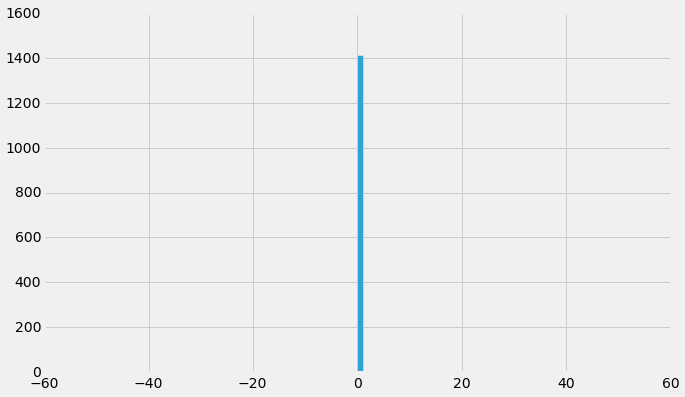

In [49]:
plt.hist(model.weights, bins=100, range=[-50,50]);

To check the performance of the model, we define a function that takes a data RDD and a model as parameters and computes the error:

In [ ]:
def check_model(data, model) : 
    """Calculates the model error on the data
    
    Arguments: 
        
        data: the data RDD
        
        model: the classification model
        
    Returns:
    
        the error, which is the fraction of incorrectly predicted elements
    """
    
    error = (data.map(lambda p: (p.label, model.predict(p.features)))
                 .filter(lambda (v,p): v!=p).count())/float(data.count())
    return error

In [ ]:
en_count_train = training.filter(lambda lp: lp.label == 0).count()
de_count_train = training.filter(lambda lp: lp.label == 1).count()
en_count_valid = validation.filter(lambda lp: lp.label == 0).count()
de_count_valid = validation.filter(lambda lp: lp.label == 1).count()

In [ ]:
train_error = check_model(training, model)/(1.*de_count_train/en_count_train)
print("Training Error = " + str(train_error))
validation_error = check_model(validation, model)/(1.*de_count_valid/en_count_valid)
print("Validation Error = " + str(validation_error))

In [174]:
en_error = check_model(training.filter(lambda lp: lp.label == 0), svm_model)
de_error = check_model(training.filter(lambda lp: lp.label == 1), svm_model)
en_valid_error = check_model(validation.filter(lambda lp: lp.label == 0), svm_model)
de_valid_error = check_model(validation.filter(lambda lp: lp.label == 1), svm_model)

In [175]:
de_valid_error

1.0

For fun, lets create a function that will score a new string of text: 

In [176]:
def predict_language(text, model) : 
    """Predict the language given the pre-trained model
    
    Arguments: 
        text: a string
        
        model: the trained logistic regression model
    """
    vec = vectorize_doc(text.replace(' ','_'), top_ngrams_dict_b.value, [1,2])
    
    return model.predict(vec)

Try it out! Enter your own sentence:

In [159]:
text = "a dog bit me"
predict_language(text, model)

0

In [166]:
predict_language('in der schweiz', model)

1

### Which character sequences define each language? 

Here we'll use the weights of the trained model to identify the words with the lowest weights (i.e. those that pull a prediction toward zero) and the highest weights (those that pull a prediction toward 1). 

In [161]:
sorted_weights = np.argsort(model.weights)

top_ngram_inds = {v:k for k,v in top_ngrams_dict.iteritems()}

print('top 50 english and german ngrams:')
for i in range(50): 
    eng_ind = sorted_weights[i]
    ger_ind = sorted_weights[len(top_ngram_inds)-i-1]
    print('%s\t%d\t%s\t%d'%(top_ngram_inds[eng_ind], model.weights[eng_ind], 
                            top_ngram_inds[ger_ind], model.weights[ger_ind]))

top 50 english and german ngrams:
_	-333	e	429
t_	0	n	57
ew	0	u	0
et	0	h_w	0
eu	0	mlh	0
ex	0	mln	0
ey	0	mlr	0
eb	0	fue	0
ec	0	wou	0
ev	0	aid	0
lan	0	ful	0
ef	0	h_v	0
eg	0	h_t	0
ed	0	gan	0
ee	0	h_u	0
oul	0	h_s	0
oum	0	n_z	0
eh	0	n_t	0
ei	0	n_u	0
ea	0	is	0
ep	0	ir	0
es	0	n_p	0
er	0	ld_	0
s_d	0	pri	0
bli	0	n_r	0
rei	0	fra	0
e_	0	w_	0
s_a	0	om_	0
reu	0	con	0
ret	0	pre	0
s_z	0	had	0
en	0	p_	0
res	0	du_	0
s_v	0	pr	0
s_w	0	fre	0
s_t	0	pl	0
s_u	0	pu	0
s_r	0	fro	0
s_s	0	pa	0
s_p	0	pf	0
hl_	0	pe	0
rer	0	dur	0
s_g	0	pi	0
el	0	ann	0
m_t	0	it	0
ls	0	iv	0
lr	0	und	0
lu	0	rit	0
lt	0	th_	0
owe	0	nin	0


Some other ideas for things you could do with this dataset: 

* build a regression model to predict year of publication
* run a clustering algorithm on the full language data
* do clustering on the english books and see if sub-groups of the language pop up
* cluster by author -- do certain authors write in similar ways?

In [179]:
sc.stop()